## Load Single Model Profiles

In [1]:
from single_model_profiles import create_model_profile_df as create_df

In [2]:
nmt_relative_path = "../results/single_model_profs/tf-nmt"
lstm_relative_path = "../results/single_model_profs/tf-lstm"
lang_detect_relative_path = "../results/single_model_profs/tf-lang-detect"

In [3]:
nmt_df = create_df(nmt_relative_path)[1]
lstm_df = create_df(lstm_relative_path)[1]
lang_detect_df = create_df(lang_detect_relative_path)[1]

In [4]:
import pandas as pd
import numpy as np
import sys
import os
import math

## Find Optimal Batch Sizes

In [5]:
def config_value(cost, throughput):
    return float(throughput) / float(cost)

In [6]:
def find_optimal_batch_config(df, slo=None, rf=1):
    slim_df = df[["mean_batch_size", "mean_throughput_qps", "cost", "p99_latency"]]
    best_config = None
    best_value = 0
    for idx, row in slim_df.iterrows():
        batch_size = row["mean_batch_size"]
        throughput = row["mean_throughput_qps"]
        adjusted_throughput = throughput / float(rf)
        cost = row["cost"]
        latency = row["p99_latency"]
        value = config_value(cost, adjusted_throughput)
        if value > best_value and ((slo == None) or (latency <= slo)):
            best_config = (batch_size, adjusted_throughput, latency)
            best_value = value
        
    return best_config
    
find_optimal_batch_config(lang_detect_df, slo=None)

(30.865079365079364, 83.101411326813789, 1.13408453)

In [7]:
nmt_config = find_optimal_batch_config(nmt_df)
lstm_config = find_optimal_batch_config(lstm_df)
lang_detect_config = find_optimal_batch_config(lang_detect_df)

## Enumerate Pipeline Configurations

In [8]:
def get_configs(branches, slo=None):
    all_configs = {}
    for branch in branches:
        branch_configs = branch_helper(branch, slo_budget=slo)
        if not branch_configs:
            break
        for config in branch_configs:
            all_configs = all_configs.copy()
            all_configs.update(config)
        
    return all_configs
                    
def branch_helper(branch, slo_budget):
    branch = list(branch)
    model_name, model_df, model_rf = branch.pop(0)
    if len(branch) == 0:
        optimal_config = find_optimal_batch_config(model_df, slo=slo_budget, rf=model_rf)
        if not optimal_config:
            return None
        else:
            return [{model_name : optimal_config}]
    else:
        while True:
            optimal_config = find_optimal_batch_config(model_df, slo=slo_budget, rf=model_rf)
            if not optimal_config:
                return None
            else:
                batch_size, throughput, latency = optimal_config
                if slo_budget:
                    new_budget = slo_budget - latency
                else:
                    new_budget = slo_budget
                next_configs = branch_helper(branch, new_budget)
                if next_configs:
                    return [{model_name : optimal_config}] + next_configs
                else:
                    # Configuration was bad, try another
                    model_df = model_df[model_df.mean_batch_size != batch_size]  
                    
def get_min_lat_configs(branches):
    all_models = []
    for branch in branches:
        all_models = all_models + branch
        
    all_configs = {}
    while len(all_models) > 0:
        model_name, model_df, model_rf = all_models.pop()
        min_df = model_df[model_df.mean_batch_size == 1.0]
        min_df = min_df[["mean_throughput_qps", "p99_latency"]]
        for idx, row in min_df.iterrows():
            throughput = row["mean_throughput_qps"]
            adjusted_throughput = float(throughput) / model_rf
            latency = row["p99_latency"]
            all_configs[model_name] = (1.0, adjusted_throughput, latency)
            break
        
    return all_configs
        

In [9]:
branch = [("tf-lang-detect", lang_detect_df, 1.0), ("tf-nmt", nmt_df, .16), ("tf-lstm", lstm_df, .47)]
branches = [branch]

In [10]:
all_configs = get_configs(branches, slo=None)

## Determine Replication Strategy

In [11]:
def get_replications(gpu_configs, cpu_configs, num_gpus=8):
    
    def get_bottleneck_model(reps, configs):
        bottleneck_model_name = None
        bottleneck_throughput = None
        for model_name, config in configs.iteritems():
            _, model_throughput, _ = config
            total_throughput = reps[model_name] * model_throughput
            if not bottleneck_throughput or total_throughput < bottleneck_throughput:
                bottleneck_model_name = model_name
                bottleneck_throughput = total_throughput
                
        return bottleneck_model_name, bottleneck_throughput
        
    
    all_configs = gpu_configs.copy()
    all_configs.update(cpu_configs)
    
    curr_reps = {}
    for model_name, _ in all_configs.iteritems():
        curr_reps[model_name] = 1
        if model_name in gpu_configs:
            num_gpus -= 1
        
    all_reps = []
        
    while True:
        bottleneck_model_name, bottleneck_throughput = get_bottleneck_model(curr_reps, all_configs)
        if bottleneck_model_name in gpu_configs:
            if num_gpus == 0:
                break
            else:
                num_gpus -= 1
                
        all_reps.append((curr_reps.copy(), bottleneck_throughput))
        curr_reps[bottleneck_model_name] = curr_reps[bottleneck_model_name] + 1
        
    all_reps.append((curr_reps.copy(), bottleneck_throughput))
    
    return all_reps

In [12]:
all_configs 

{'tf-lang-detect': (30.865079365079364, 83.101411326813789, 1.13408453),
 'tf-lstm': (20.891666666666666, 2401.5572094085601, 0.086221379999999986),
 'tf-nmt': (63.277777777777779, 111.38132710082968, 10.8846778)}

In [13]:
gpu_configs = {k: all_configs[k] for k in ('tf-nmt',)}
cpu_configs = {k: all_configs[k] for k in ('tf-lstm', 'tf-lang-detect')}

In [14]:
get_replications(gpu_configs=gpu_configs, cpu_configs=cpu_configs, num_gpus=8)

[({'tf-lang-detect': 1, 'tf-lstm': 1, 'tf-nmt': 1}, 83.101411326813789),
 ({'tf-lang-detect': 2, 'tf-lstm': 1, 'tf-nmt': 1}, 111.38132710082968),
 ({'tf-lang-detect': 2, 'tf-lstm': 1, 'tf-nmt': 2}, 166.20282265362758),
 ({'tf-lang-detect': 3, 'tf-lstm': 1, 'tf-nmt': 2}, 222.76265420165936),
 ({'tf-lang-detect': 3, 'tf-lstm': 1, 'tf-nmt': 3}, 249.30423398044138),
 ({'tf-lang-detect': 4, 'tf-lstm': 1, 'tf-nmt': 3}, 332.40564530725516),
 ({'tf-lang-detect': 5, 'tf-lstm': 1, 'tf-nmt': 3}, 334.14398130248901),
 ({'tf-lang-detect': 5, 'tf-lstm': 1, 'tf-nmt': 4}, 415.50705663406893),
 ({'tf-lang-detect': 6, 'tf-lstm': 1, 'tf-nmt': 4}, 445.52530840331872),
 ({'tf-lang-detect': 6, 'tf-lstm': 1, 'tf-nmt': 5}, 498.60846796088276),
 ({'tf-lang-detect': 7, 'tf-lstm': 1, 'tf-nmt': 5}, 556.90663550414843),
 ({'tf-lang-detect': 7, 'tf-lstm': 1, 'tf-nmt': 6}, 581.70987928769648),
 ({'tf-lang-detect': 8, 'tf-lstm': 1, 'tf-nmt': 6}, 664.81129061451031),
 ({'tf-lang-detect': 9, 'tf-lstm': 1, 'tf-nmt': 6},

## Replications and expected throughputs for varying SLOs

### 3000ms

In [15]:
three_second_configs = get_configs(list(branches), slo=3.0)
three_second_gpu_configs = {k: three_second_configs[k] for k in ('tf-nmt',)}
three_second_cpu_configs = {k: three_second_configs[k] for k in ('tf-lstm', 'tf-lang-detect')}
three_second_reps = get_replications(gpu_configs=three_second_gpu_configs, cpu_configs=three_second_cpu_configs, num_gpus=8)

In [16]:
three_second_reps

[({'tf-lang-detect': 1, 'tf-lstm': 1, 'tf-nmt': 1}, 58.771198056514137),
 ({'tf-lang-detect': 1, 'tf-lstm': 1, 'tf-nmt': 2}, 81.88608307158475),
 ({'tf-lang-detect': 2, 'tf-lstm': 1, 'tf-nmt': 2}, 117.54239611302827),
 ({'tf-lang-detect': 2, 'tf-lstm': 1, 'tf-nmt': 3}, 163.7721661431695),
 ({'tf-lang-detect': 3, 'tf-lstm': 1, 'tf-nmt': 3}, 176.3135941695424),
 ({'tf-lang-detect': 3, 'tf-lstm': 1, 'tf-nmt': 4}, 235.08479222605655),
 ({'tf-lang-detect': 3, 'tf-lstm': 1, 'tf-nmt': 5}, 245.65824921475425),
 ({'tf-lang-detect': 4, 'tf-lstm': 1, 'tf-nmt': 5}, 293.8559902825707),
 ({'tf-lang-detect': 4, 'tf-lstm': 1, 'tf-nmt': 6}, 327.544332286339),
 ({'tf-lang-detect': 5, 'tf-lstm': 1, 'tf-nmt': 6}, 352.6271883390848),
 ({'tf-lang-detect': 5, 'tf-lstm': 1, 'tf-nmt': 7}, 409.43041535792372),
 ({'tf-lang-detect': 6, 'tf-lstm': 1, 'tf-nmt': 7}, 411.39838639559895),
 ({'tf-lang-detect': 6, 'tf-lstm': 1, 'tf-nmt': 8}, 470.1695844521131)]

### 5000ms

In [85]:
five_second_configs = get_configs(list(branches), slo=5.0)
five_second_gpu_configs = {k: five_second_configs[k] for k in ('tf-nmt',)}
five_second_cpu_configs = {k: five_second_configs[k] for k in ('tf-lstm', 'tf-lang-detect')}
five_second_reps = get_replications(gpu_configs=five_second_gpu_configs, cpu_configs=five_second_cpu_configs, num_gpus=8)

In [86]:
five_second_reps

[({'tf-lang-detect': 1, 'tf-lstm': 1, 'tf-nmt': 1}, 77.806702553642637),
 ({'tf-lang-detect': 1, 'tf-lstm': 1, 'tf-nmt': 2}, 83.101411326813789),
 ({'tf-lang-detect': 2, 'tf-lstm': 1, 'tf-nmt': 2}, 155.61340510728527),
 ({'tf-lang-detect': 2, 'tf-lstm': 1, 'tf-nmt': 3}, 166.20282265362758),
 ({'tf-lang-detect': 3, 'tf-lstm': 1, 'tf-nmt': 3}, 233.4201076609279),
 ({'tf-lang-detect': 3, 'tf-lstm': 1, 'tf-nmt': 4}, 249.30423398044138),
 ({'tf-lang-detect': 4, 'tf-lstm': 1, 'tf-nmt': 4}, 311.22681021457055),
 ({'tf-lang-detect': 4, 'tf-lstm': 1, 'tf-nmt': 5}, 332.40564530725516),
 ({'tf-lang-detect': 5, 'tf-lstm': 1, 'tf-nmt': 5}, 389.0335127682132),
 ({'tf-lang-detect': 5, 'tf-lstm': 1, 'tf-nmt': 6}, 415.50705663406893),
 ({'tf-lang-detect': 6, 'tf-lstm': 1, 'tf-nmt': 6}, 466.84021532185579),
 ({'tf-lang-detect': 6, 'tf-lstm': 1, 'tf-nmt': 7}, 498.60846796088276),
 ({'tf-lang-detect': 7, 'tf-lstm': 1, 'tf-nmt': 7}, 544.6469178754985),
 ({'tf-lang-detect': 7, 'tf-lstm': 1, 'tf-nmt': 8}, 58

### Max Thru

In [87]:
max_thru_configs = get_configs(list(branches), slo=None)
max_thru_gpu_configs = {k: max_thru_configs[k] for k in ('tf-nmt',)}
max_thru_cpu_configs = {k: max_thru_configs[k] for k in ('tf-lstm', 'tf-lang-detect')}
max_thru_reps = get_replications(gpu_configs=max_thru_gpu_configs, cpu_configs=max_thru_cpu_configs, num_gpus=8)

In [88]:
max_thru_reps

[({'tf-lang-detect': 1, 'tf-lstm': 1, 'tf-nmt': 1}, 83.101411326813789),
 ({'tf-lang-detect': 2, 'tf-lstm': 1, 'tf-nmt': 1}, 111.38132710082968),
 ({'tf-lang-detect': 2, 'tf-lstm': 1, 'tf-nmt': 2}, 166.20282265362758),
 ({'tf-lang-detect': 3, 'tf-lstm': 1, 'tf-nmt': 2}, 222.76265420165936),
 ({'tf-lang-detect': 3, 'tf-lstm': 1, 'tf-nmt': 3}, 249.30423398044138),
 ({'tf-lang-detect': 4, 'tf-lstm': 1, 'tf-nmt': 3}, 332.40564530725516),
 ({'tf-lang-detect': 5, 'tf-lstm': 1, 'tf-nmt': 3}, 334.14398130248901),
 ({'tf-lang-detect': 5, 'tf-lstm': 1, 'tf-nmt': 4}, 415.50705663406893),
 ({'tf-lang-detect': 6, 'tf-lstm': 1, 'tf-nmt': 4}, 445.52530840331872),
 ({'tf-lang-detect': 6, 'tf-lstm': 1, 'tf-nmt': 5}, 498.60846796088276),
 ({'tf-lang-detect': 7, 'tf-lstm': 1, 'tf-nmt': 5}, 556.90663550414843),
 ({'tf-lang-detect': 7, 'tf-lstm': 1, 'tf-nmt': 6}, 581.70987928769648),
 ({'tf-lang-detect': 8, 'tf-lstm': 1, 'tf-nmt': 6}, 664.81129061451031),
 ({'tf-lang-detect': 9, 'tf-lstm': 1, 'tf-nmt': 6},

### Min Lat

In [89]:
min_lat_configs = get_min_lat_configs(list(branches))
min_lat_gpu_configs = {k: min_lat_configs[k] for k in ('tf-nmt',)}
min_lat_cpu_configs = {k: min_lat_configs[k] for k in ('tf-lstm', 'tf-lang-detect')}
min_lat_reps = get_replications(gpu_configs=min_lat_gpu_configs, cpu_configs=min_lat_cpu_configs, num_gpus=8)

In [90]:
min_lat_reps

[({'tf-lang-detect': 1, 'tf-lstm': 1, 'tf-nmt': 1}, 15.655824241934365),
 ({'tf-lang-detect': 1, 'tf-lstm': 1, 'tf-nmt': 2}, 31.31164848386873),
 ({'tf-lang-detect': 1, 'tf-lstm': 1, 'tf-nmt': 3}, 46.96747272580309),
 ({'tf-lang-detect': 1, 'tf-lstm': 1, 'tf-nmt': 4}, 62.62329696773746),
 ({'tf-lang-detect': 1, 'tf-lstm': 1, 'tf-nmt': 5}, 75.44628779686538),
 ({'tf-lang-detect': 2, 'tf-lstm': 1, 'tf-nmt': 5}, 78.27912120967183),
 ({'tf-lang-detect': 2, 'tf-lstm': 1, 'tf-nmt': 6}, 93.93494545160618),
 ({'tf-lang-detect': 2, 'tf-lstm': 1, 'tf-nmt': 7}, 103.85934123498701),
 ({'tf-lang-detect': 2, 'tf-lstm': 2, 'tf-nmt': 7}, 109.59076969354055),
 ({'tf-lang-detect': 2, 'tf-lstm': 2, 'tf-nmt': 8}, 125.24659393547492)]

In [91]:
min_lat_configs

{'tf-lang-detect': (1.0, 75.44628779686538, 0.026418050000000002),
 'tf-lstm': (1.0, 103.85934123498701, 0.023262100000000001),
 'tf-nmt': (1.0, 15.655824241934365, 3.0595581599999995)}

## Plots

In [92]:
from matplotlib import pyplot as plt
from utils import COST_PER_GPU, COST_PER_CPU
% matplotlib inline

In [93]:
def get_thrus_costs(gpu_configs, reps):
    costs = []
    thrus = []
    for rep_config, throughput in reps:
        total_cost = 0
        for model_name, num_reps in rep_config.iteritems():
            cost = num_reps * COST_PER_CPU
            if model_name in gpu_configs:
                cost += num_reps * COST_PER_GPU
            total_cost += cost

        costs.append(total_cost)
        thrus.append(throughput)

    return thrus, costs

In [94]:
min_lat_thrus, min_lat_costs = get_thrus_costs(min_lat_gpu_configs, min_lat_reps)
max_thru_thrus, max_thru_costs = get_thrus_costs(max_thru_gpu_configs, max_thru_reps)
three_second_thrus, three_second_costs = get_thrus_costs(three_second_gpu_configs, three_second_reps)
five_second_thrus, five_second_costs = get_thrus_costs(five_second_gpu_configs, five_second_reps)

## Load E2E Results

In [95]:
from end_to_end_profiles import load_end_to_end_experiment as load_e2e

In [96]:
min_lat_relative_path = "../results/e2e_profs/systemx/tf_driver_2/min_latency"
max_thru_relative_path = "../results/e2e_profs/systemx/tf_driver_2/max_throughput"
three_second_relative_path = "../results/e2e_profs/systemx/tf_driver_2/3000ms"
five_second_relative_path = "../results/e2e_profs/systemx/tf_driver_2/5000ms"

In [97]:
e2e_min_lat_df = load_e2e("min", min_lat_relative_path)[0]
e2e_max_thru_df = load_e2e("max", max_thru_relative_path)[0]
e2e_three_second_df = load_e2e("3000ms", three_second_relative_path)[0]
e2e_five_second_df = load_e2e("5000ms", five_second_relative_path)[0]

## Plot Throughput vs Cost

In [98]:
def get_e2e_thrus_costs(e2e_df):
    thrus = []
    costs = []
    slim_df = e2e_df[["mean_throughput", "cost"]].sort_values("cost")
    for idx, row in slim_df.iterrows():
        thru = row["mean_throughput"]
        cost = row["cost"]
        thrus.append(thru)
        costs.append(cost)
        
    return thrus, costs

In [99]:
e2e_min_lat_thrus, e2e_min_lat_costs = get_e2e_thrus_costs(e2e_min_lat_df)
e2e_max_thru_thrus, e2e_max_thru_costs = get_e2e_thrus_costs(e2e_max_thru_df)
e2e_three_second_thrus, e2e_three_second_costs = get_e2e_thrus_costs(e2e_three_second_df)
e2e_five_second_thrus, e2e_five_second_costs = get_e2e_thrus_costs(e2e_five_second_df)

Percentage differences (relative to expectation): [-0.02425788  0.02927993 -0.03191852 -0.02167152 -0.04190854 -0.07154127
 -0.07496284 -0.07385624]


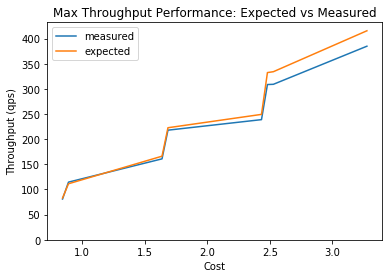

In [100]:
common_len = min(len(max_thru_thrus), len(e2e_max_thru_thrus))
plot_max_thru_thrus = max_thru_thrus[:common_len]
plot_e2e_max_thru_thrus = e2e_max_thru_thrus[:common_len]
plot_max_thru_costs = max_thru_costs[:common_len]

diffs = np.array(plot_e2e_max_thru_thrus) - np.array(plot_max_thru_thrus)
print("Percentage differences (relative to expectation): {}".format(diffs / plot_max_thru_thrus))

plt.plot(plot_max_thru_costs, plot_e2e_max_thru_thrus, label="measured")
plt.plot(plot_max_thru_costs, plot_max_thru_thrus, label="expected")
plt.legend()
plt.ylim(bottom=0)
plt.xlabel("Cost")
plt.ylabel("Throughput (qps)")
plt.title("Max Throughput Performance: Expected vs Measured")

Percentage differences (relative to expectation): [ 0.12043034  0.21864307  0.21577159  0.20786138  0.00122788  0.20801975
  0.18150255  0.17945199]


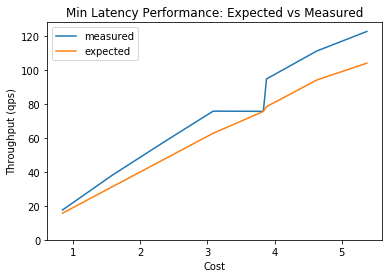

In [101]:
common_len = min(len(min_lat_thrus), len(e2e_min_lat_thrus))
plot_min_lat_thrus = min_lat_thrus[:common_len]
plot_e2e_min_lat_thrus = e2e_min_lat_thrus[:common_len]
plot_min_lat_costs = min_lat_costs[:common_len]

diffs = np.array(plot_e2e_min_lat_thrus) - np.array(plot_min_lat_thrus)
print("Percentage differences (relative to expectation): {}".format(diffs / plot_min_lat_thrus))

plt.plot(plot_min_lat_costs, plot_e2e_min_lat_thrus, label="measured")
plt.plot(plot_min_lat_costs, plot_min_lat_thrus, label="expected")
plt.legend()
plt.ylim(bottom=0)
plt.xlabel("Cost")
plt.ylabel("Throughput (qps)")
plt.title("Min Latency Performance: Expected vs Measured")

Percentage differences (relative to expectation): [ 0.0395163  -0.00868169  0.07145479 -0.02364677  0.05799868  0.00770924
 -0.03272003  0.01886312]


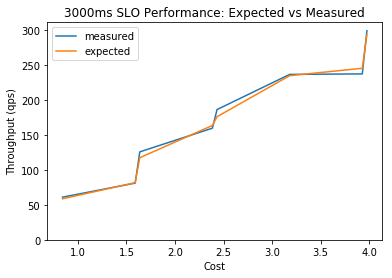

In [102]:
common_len = min(len(three_second_thrus), len(e2e_three_second_thrus))
plot_three_second_thrus = three_second_thrus[:common_len]
plot_e2e_three_second_thrus = e2e_three_second_thrus[:common_len]
plot_three_second_costs = three_second_costs[:common_len]

diffs = np.array(plot_e2e_three_second_thrus) - np.array(plot_three_second_thrus)
print("Percentage differences (relative to expectation): {}".format(diffs / plot_three_second_thrus))

plt.plot(plot_three_second_costs, plot_e2e_three_second_thrus, label="measured")
plt.plot(plot_three_second_costs, plot_three_second_thrus, label="expected")
plt.legend()
plt.ylim(bottom=0)
plt.xlabel("Cost")
plt.ylabel("Throughput (qps)")
plt.title("3000ms SLO Performance: Expected vs Measured")

Percentage differences (relative to expectation): [-0.06329417 -0.02155654  0.0276648  -0.03471587 -0.03538034 -0.04266678
  0.0076655  -0.05040816]


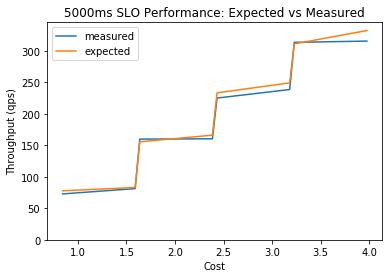

In [103]:
common_len = min(len(five_second_thrus), len(e2e_five_second_thrus))
plot_five_second_thrus = five_second_thrus[:common_len]
plot_e2e_five_second_thrus = e2e_five_second_thrus[:common_len]
plot_five_second_costs = five_second_costs[:common_len]

diffs = np.array(plot_e2e_five_second_thrus) - np.array(plot_five_second_thrus)
print("Percentage differences (relative to expectation): {}".format(diffs / plot_five_second_thrus))

plt.plot(plot_five_second_costs, plot_e2e_five_second_thrus, label="measured")
plt.plot(plot_five_second_costs, plot_five_second_thrus, label="expected")
plt.legend()
plt.ylim(bottom=0)
plt.xlabel("Cost")
plt.ylabel("Throughput (qps)")
plt.title("5000ms SLO Performance: Expected vs Measured")

## Plot Latencies

In [104]:
def get_latency_stats(df):
    all_lats = []
    means = []
    stds = []
    p99s = []
    costs = []
    for idx, row in df.sort_values("cost").iterrows():
        lats = row["latency"]
        lats = lats.flatten()
        all_lats.append(lats)
        mean = np.mean(lats)
        means.append(mean)
        std = np.std(lats)
        stds.append(std)
        p99 = np.percentile(lats, 99)
        p99s.append(p99)
        cost = row["cost"]
        costs.append(cost)
        
    return costs, all_lats, means, stds, p99s

In [105]:
e2e_min_lat_costs, e2e_min_lat_lats, e2e_min_lat_means, e2e_min_lat_stds, e2e_min_lat_p99s = get_latency_stats(e2e_min_lat_df)
e2e_max_thru_costs, e2e_max_thru_lats, e2e_max_thru_means, e2e_max_thru_stds, e2e_max_thru_p99s = get_latency_stats(e2e_max_thru_df)
e2e_three_second_costs, e2e_three_second_lats, e2e_three_second_means, e2e_three_second_stds, e2e_three_second_p99s = get_latency_stats(e2e_three_second_df)
e2e_five_second_costs, e2e_five_second_lats, e2e_five_second_means, e2e_five_second_stds, e2e_five_second_p99s = get_latency_stats(e2e_five_second_df)

### Min Latency

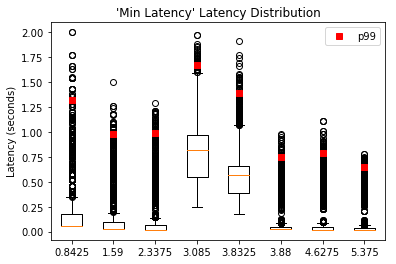

In [106]:
plt.ylabel("Latency (seconds)")
plt.title("'Min Latency' Latency Distribution")
plt.boxplot(e2e_min_lat_lats)
plt.plot(range(1, len(e2e_min_lat_costs) + 1), e2e_min_lat_p99s, "rs", label="p99")
plt.xticks(range(1, len(e2e_min_lat_costs) + 1), e2e_min_lat_costs)
plt.legend()

In [107]:
plot_min_lat_thrus

[15.655824241934365,
 31.31164848386873,
 46.96747272580309,
 62.62329696773746,
 75.44628779686538,
 78.27912120967183,
 93.93494545160618,
 103.85934123498701]

### Max Throughput

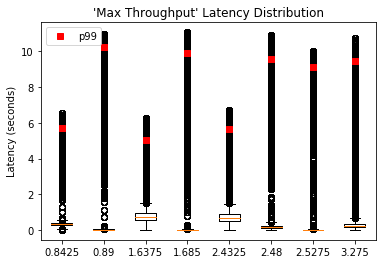

In [108]:
plt.ylabel("Latency (seconds)")
plt.title("'Max Throughput' Latency Distribution")
plt.boxplot(e2e_max_thru_lats)
plt.plot(range(1, len(e2e_max_thru_costs) + 1), e2e_max_thru_p99s, "rs", label="p99")
plt.xticks(range(1, len(e2e_max_thru_costs) + 1), e2e_max_thru_costs)
plt.legend()

### 3000ms

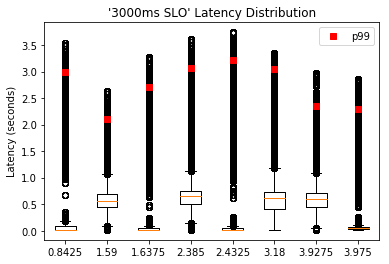

In [109]:
plt.ylabel("Latency (seconds)")
plt.title("'3000ms SLO' Latency Distribution")
plt.boxplot(e2e_three_second_lats)
plt.plot(range(1, len(e2e_three_second_costs) + 1), e2e_three_second_p99s, "rs", label="p99")
plt.xticks(range(1, len(e2e_three_second_costs) + 1), e2e_three_second_costs)
plt.legend()

### 5000ms

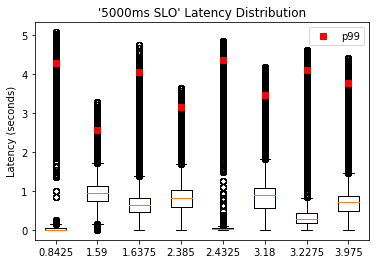

In [110]:
plt.ylabel("Latency (seconds)")
plt.title("'5000ms SLO' Latency Distribution")
plt.boxplot(e2e_five_second_lats)
plt.plot(range(1, len(e2e_five_second_costs) + 1), e2e_five_second_p99s, "rs", label="p99")
plt.xticks(range(1, len(e2e_five_second_costs) + 1), e2e_five_second_costs)
plt.legend()